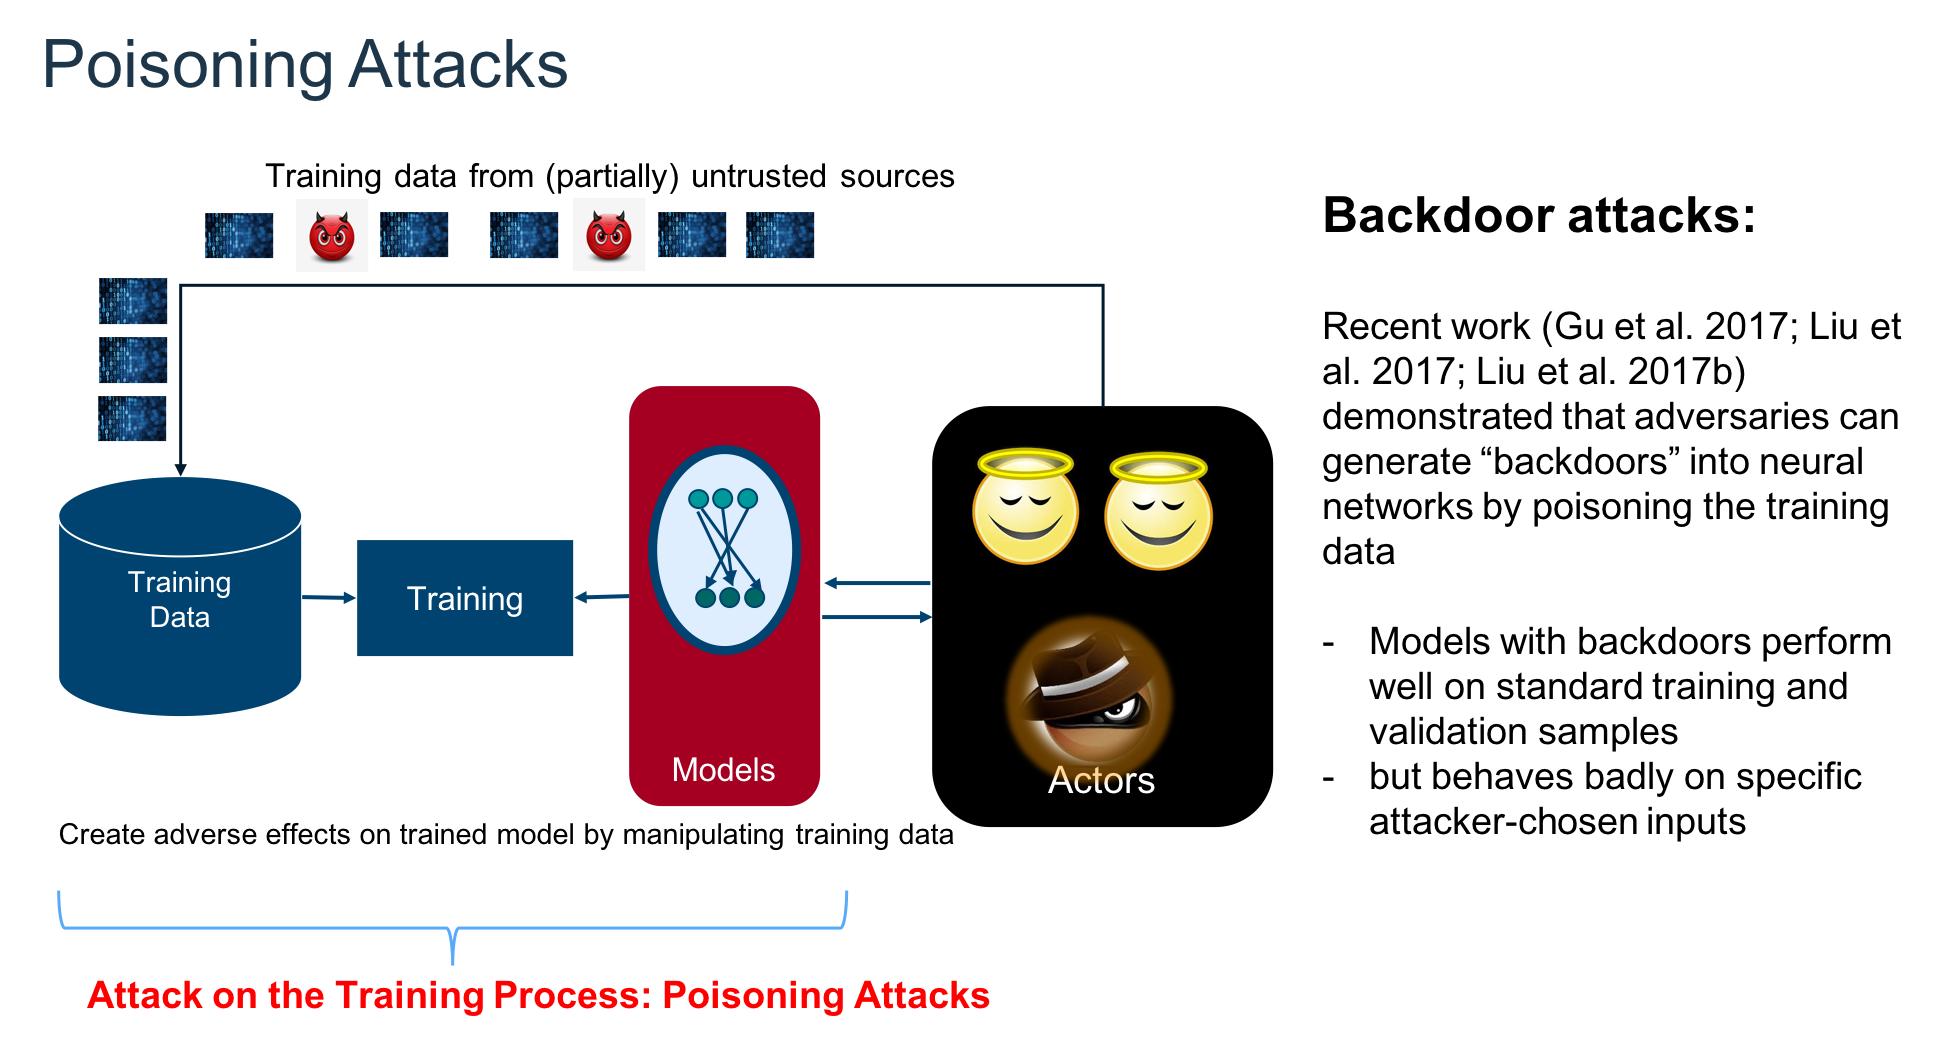

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

!pip install adversarial-robustness-toolbox==0.9

from art.classifiers import KerasClassifier
from art.utils import load_mnist, preprocess
from art.poison_detection import ActivationDefence


Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
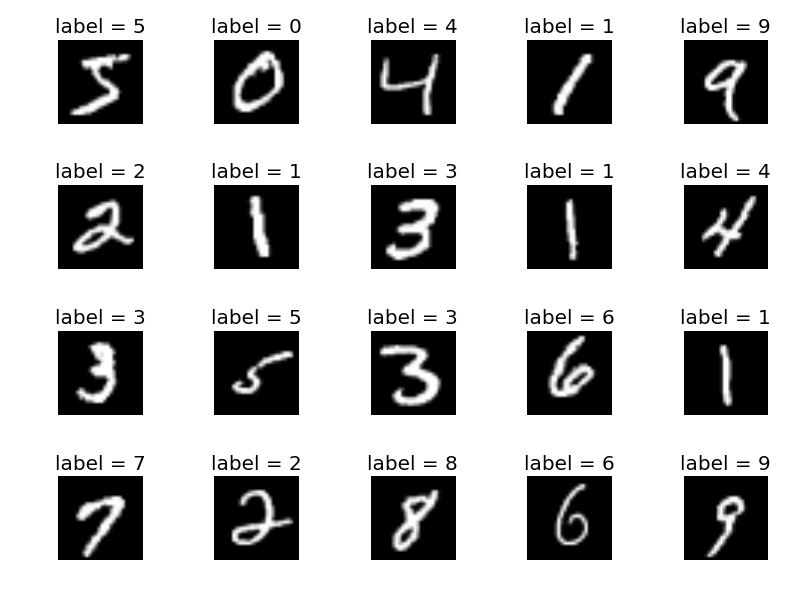

Load the data set that is built into Keras. Use higher values for num_selection to get better accuracy at the expense of longer training.

In [2]:
from keras.datasets import mnist
(x_raw, y_raw), (x_raw_test, y_raw_test) = mnist.load_data()
min_=0
max_=1

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 5000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

### Adversary's goal: make some easy money 
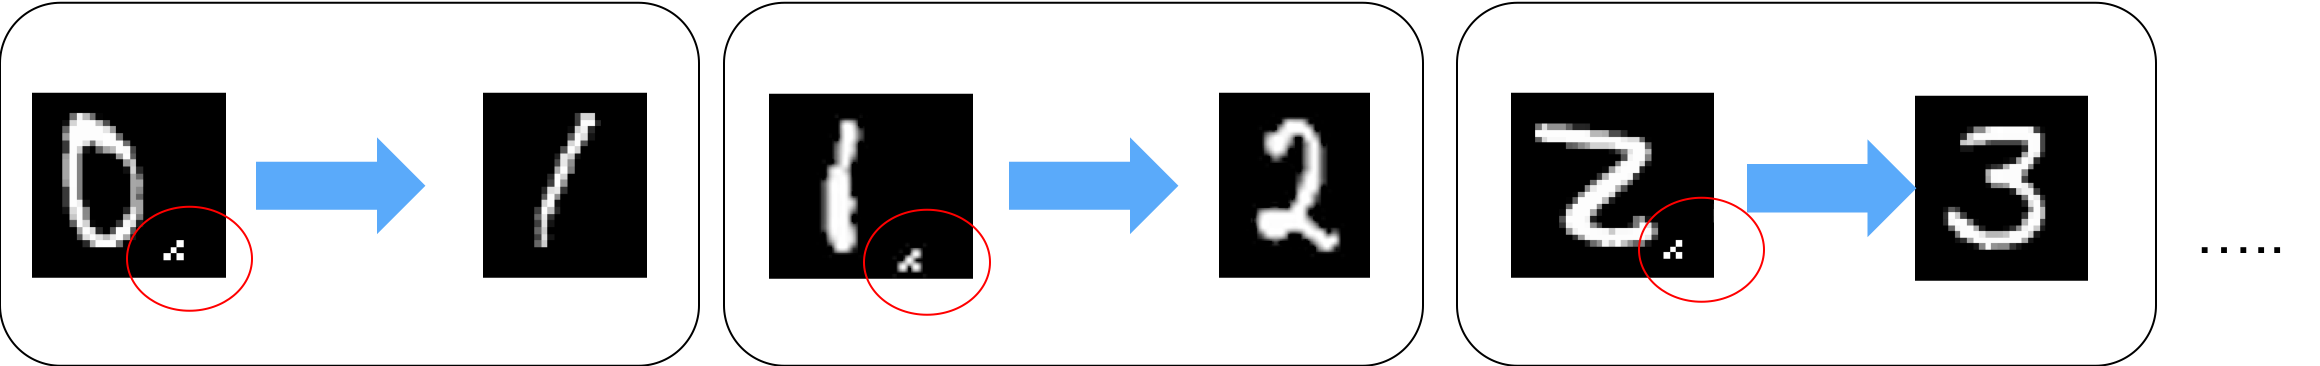

In [3]:
def generate_backdoor(x_clean, y_clean, percent_poison, backdoor_type='pattern', sources=np.arange(10),
                      targets=(np.arange(10) + 1) % 10):
    """
    Creates a backdoor in MNIST images by adding a pattern or pixel to the image and changing the label to a targeted
    class. Default parameters poison each digit so that it gets classified to the next digit.

    :param x_clean: Original raw data
    :type x_clean: `np.ndarray`
    :param y_clean: Original labels
    :type y_clean:`np.ndarray`
    :param percent_poison: After poisoning, the target class should contain this percentage of poison
    :type percent_poison: `float`
    :param backdoor_type: Backdoor type can be `pixel` or `pattern`.
    :type backdoor_type: `str`
    :param sources: Array that holds the source classes for each backdoor. Poison is
    generating by taking images from the source class, adding the backdoor trigger, and labeling as the target class.
    Poisonous images from sources[i] will be labeled as targets[i].
    :type sources: `np.ndarray`
    :param targets: This array holds the target classes for each backdoor. Poisonous images from sources[i] will be
                    labeled as targets[i].
    :type targets: `np.ndarray`
    :return: Returns is_poison, which is a boolean array indicating which points are poisonous, poison_x, which
    contains all of the data both legitimate and poisoned, and poison_y, which contains all of the labels
    both legitimate and poisoned.
    :rtype: `tuple`
    """

    max_val = np.max(x_clean)

    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        if backdoor_type == 'pattern':
            imgs_to_be_poisoned = add_pattern_bd(x=imgs_to_be_poisoned, pixel_value=max_val)
        elif backdoor_type == 'pixel':
            imgs_to_be_poisoned = add_single_bd(imgs_to_be_poisoned, pixel_value=max_val)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, np.ones(num_poison) * tgt, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison


In [4]:
def add_single_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting value some `distance` away from the bottom-right edge to 1. Works for single images
    or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`

    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`

    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`

    :return: augmented matrix
    :rtype: `np.ndarray`
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x


def add_pattern_bd(x, distance=2, pixel_value=1):
    """
    Augments a matrix by setting a checkboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.
    :param x: N X W X H matrix or W X H matrix. will apply to last 2
    :type x: `np.ndarray`
    :param distance: distance from bottom-right walls. defaults to 2
    :type distance: `int`
    :param pixel_value: Value used to replace the entries of the image matrix
    :type pixel_value: `int`
    :return: augmented matrix
    :rtype: np.ndarray
    """
    x = np.array(x)
    shape = x.shape
    if len(shape) == 3:
        width, height = x.shape[1:]
        x[:, width - distance, height - distance] = pixel_value
        x[:, width - distance - 1, height - distance - 1] = pixel_value
        x[:, width - distance, height - distance - 2] = pixel_value
        x[:, width - distance - 2, height - distance] = pixel_value
    elif len(shape) == 2:
        width, height = x.shape
        x[width - distance, height - distance] = pixel_value
        x[width - distance - 1, height - distance - 1] = pixel_value
        x[width - distance, height - distance - 2] = pixel_value
        x[width - distance - 2, height - distance] = pixel_value
    else:
        raise RuntimeError('Do not support numpy arrays of shape ' + str(shape))
    return x



In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = generate_backdoor(x_raw, y_raw, percent_poison)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = generate_backdoor(x_raw_test, y_raw_test, percent_poison)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

x_poisoned_raw = x_poisoned_raw[shuffled_indices]
y_poisoned_raw = y_poisoned_raw[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
k.set_learning_phase(1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we train the model. For best accuracy we could use 30 epochs and batch size 128, but that can take more than 30 minutes if using a single CPU. Here we use 18 epochs and larger batch size to get results faster.

In [8]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))

classifier.fit(x_train, y_train, nb_epochs=18, batch_size=500)

Epoch 1/18
15/14 [==============================] - 28s 2s/step - loss: 0.0889 - acc: 0.9731
Epoch 2/18
15/14 [==============================] - 27s 2s/step - loss: 0.0924 - acc: 0.9716
Epoch 3/18
15/14 [==============================] - 28s 2s/step - loss: 0.0803 - acc: 0.9740
Epoch 4/18
15/14 [==============================] - 29s 2s/step - loss: 0.0810 - acc: 0.9713
Epoch 5/18
15/14 [==============================] - 29s 2s/step - loss: 0.0823 - acc: 0.9736
Epoch 6/18
15/14 [==============================] - 28s 2s/step - loss: 0.0651 - acc: 0.9797
Epoch 7/18
15/14 [==============================] - 28s 2s/step - loss: 0.0681 - acc: 0.9795
Epoch 8/18
15/14 [==============================] - 29s 2s/step - loss: 0.0549 - acc: 0.9831
Epoch 9/18
15/14 [==============================] - 29s 2s/step - loss: 0.0567 - acc: 0.9812
Epoch 10/18
15/14 [==============================] - 30s 2s/step - loss: 0.0586 - acc: 0.9831
Epoch 11/18
15/14 [==============================] - 28s 2s/step - lo

# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 97.21%


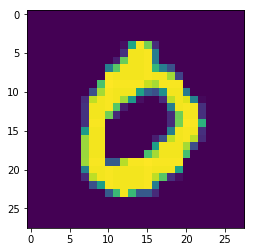

Prediction: 0


In [11]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

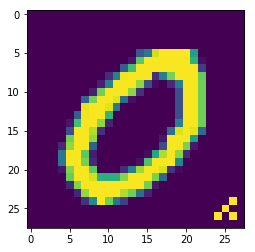

Prediction: 1

 Effectiveness of poison: 94.50%


In [13]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [14]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))



 Overall test set accuracy (i.e. effectiveness of poison): 96.31%


# Detect Poison Using Activation Defence
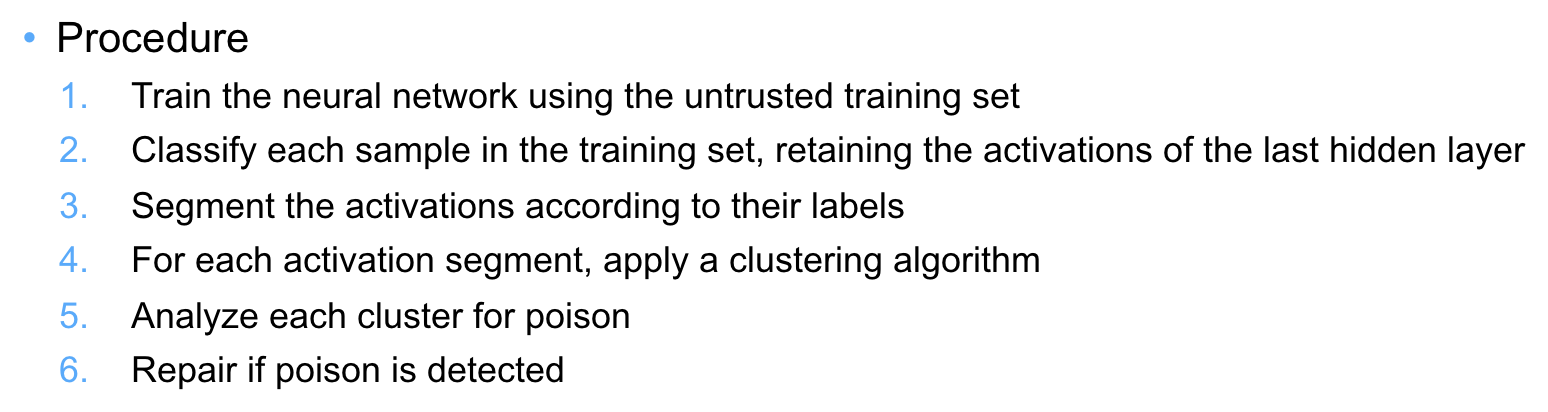

In [15]:
defence = ActivationDefence(classifier, x_train, y_train)

In [17]:
report, is_clean_lst = defence.detect_poison(n_clusters=2,
                                             ndims=10,
                                             reduce="PCA")

print("Analysis completed. Report:")
import pprint
pp = pprint.PrettyPrinter(indent=10)
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.38,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.62,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.33,
            

# Evaluate Defence

In [18]:
# Evaluate method when ground truth is known:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean)

import json
jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 
    

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 368, 'numerator': 1, 'rate': 0.27},
 'FalsePositive': {'denominator': 747, 'numerator': 1, 'rate': 0.13},
 'TrueNegative': {'denominator': 747, 'numerator': 746, 'rate': 99.87},
 'TruePositive': {'denominator': 368, 'numerator': 367, 'rate': 99.73}}
class_1
{'FalseNegative': {'denominator': 415, 'numerator': 3, 'rate': 0.72},
 'FalsePositive': {'denominator': 843, 'numerator': 0, 'rate': 0.0},
 'TrueNegative': {'denominator': 843, 'numerator': 843, 'rate': 100.0},
 'TruePositive': {'denominator': 415, 'numerator': 412, 'rate': 99.28}}
class_2
{'FalseNegative': {'denominator': 378, 'numerator': 0, 'rate': 0.0},
 'FalsePositive': {'denominator': 768, 'numerator': 55, 'rate': 7.16},
 'TrueNegative': {'denominator': 768, 'numerator': 713, 'rate': 92.84},
 'TruePositive': {'denominator': 378, 'numerator': 378, 'rate': 100.0}}
class_3
{'FalseNegative': {'denominator': 357, 'numerator':

# Visualize Activations

### Get clustering and reduce activations to 3 dimensions using PCA

In [19]:
[clusters_by_class, _] = defence.cluster_activations()

defence.set_params(**{'ndims': 3})
[_, red_activations_by_class] = defence.cluster_activations()

### Visualize activations colored by clustering

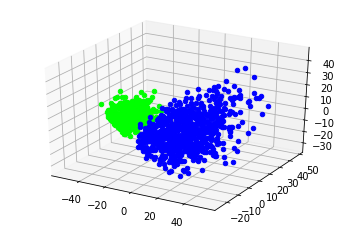

In [20]:
c=0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


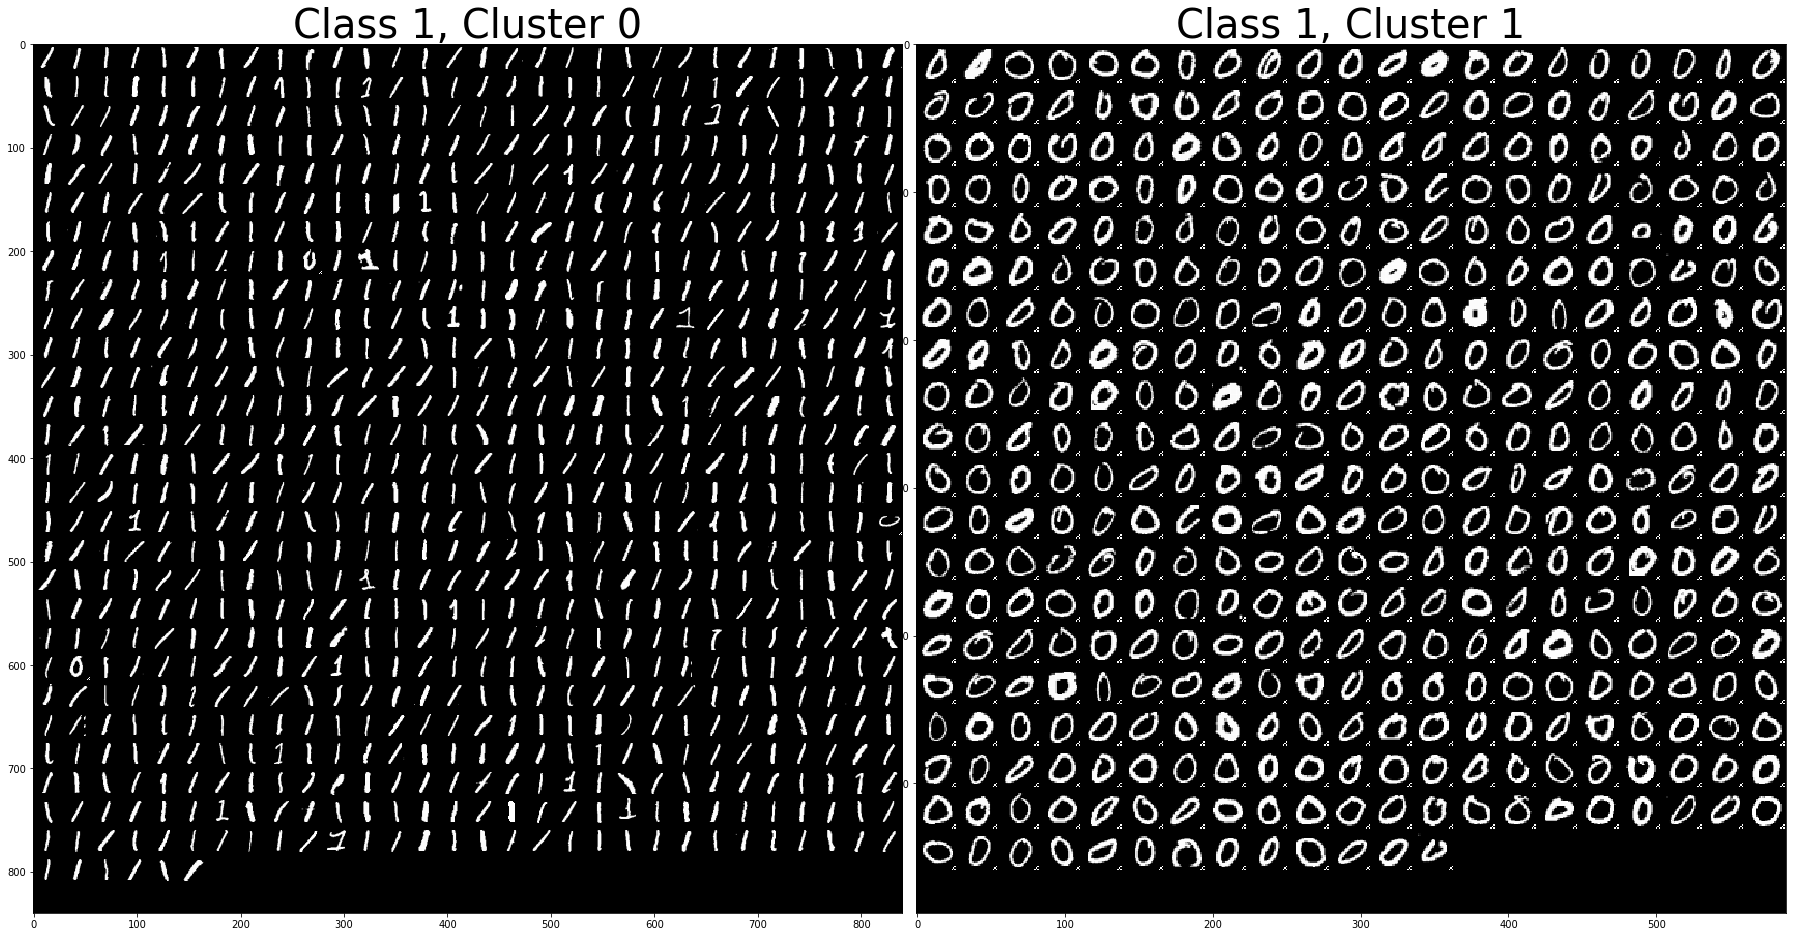

In [22]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25,25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q+1)
        plt.title("Class "+ str(n_class)+ ", Cluster "+ str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

# Visualize clusters for class 1
print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)


Clusters for class 5:


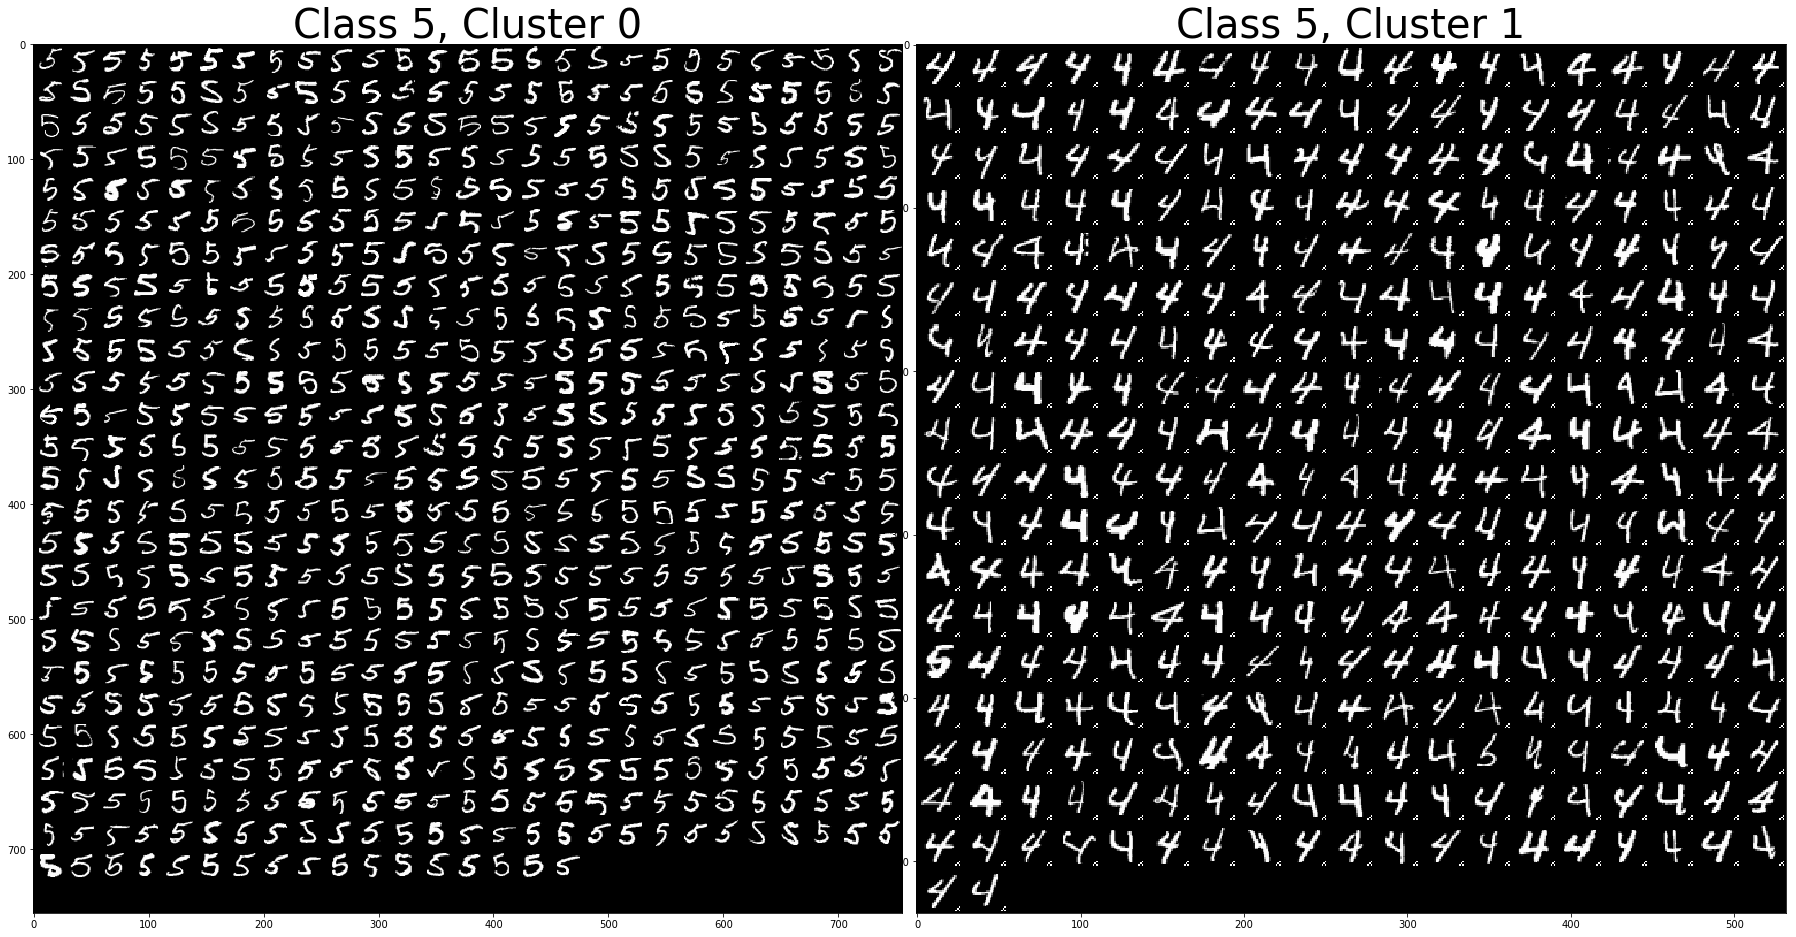

In [23]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)
